# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [58]:
X_train = pd.read_csv('dataset_X_train.csv').set_index(['index', 'subject'])
y_train = pd.read_csv('dataset_y_train.csv')
X_test = pd.read_csv('dataset_X_test.csv').set_index(['index', 'subject'])
y_test = pd.read_csv('dataset_y_test.csv')

### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

Como a base de testes é maior do que 20%, vou concatenar toda a base e fazer igual foi feito na aula, para ter uma base de validação e de testes distribuidas com a mesma quantidade de observações.

In [59]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=843941)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.25, random_state=8399230)

### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [60]:
clf = DecisionTreeClassifier(random_state=1, max_depth=4).fit(X_train, y_train)

In [61]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': clf.feature_importances_
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
best_features = feature_importance.iloc[:3]['Feature']
feature_importance.head(3)

,Feature,Importance
52,tGravityAcc-min()-X,0.283862
366,fBodyAccJerk-entropy()-X,0.259379
50,tGravityAcc-max()-Y,0.153273


### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

In [62]:
X_train = pd.read_csv('dataset_X_train.csv').set_index(['index', 'subject'])
y_train = pd.read_csv('dataset_y_train.csv')
X_test = pd.read_csv('dataset_X_test.csv').set_index(['index', 'subject'])
y_test = pd.read_csv('dataset_y_test.csv')

In [63]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

X = X[best_features]

X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=843941)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.25, random_state=8399230)

In [ ]:
clf = DecisionTreeClassifier(random_state=999889006, max_depth=20).fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 24.1 ms


In [ ]:
path = DecisionTreeClassifier(random_state=999889006).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

CPU times: total: 31.2 ms
Wall time: 27.1 ms


In [72]:
ccp_alphas_aux = np.unique(ccp_alphas)
ccp_alphas_aux = np.sort(ccp_alphas_aux)

In [75]:
clfs = []
for ccp_alpha in ccp_alphas_aux:
    clf = DecisionTreeClassifier(random_state=999889006, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs.append(clf)

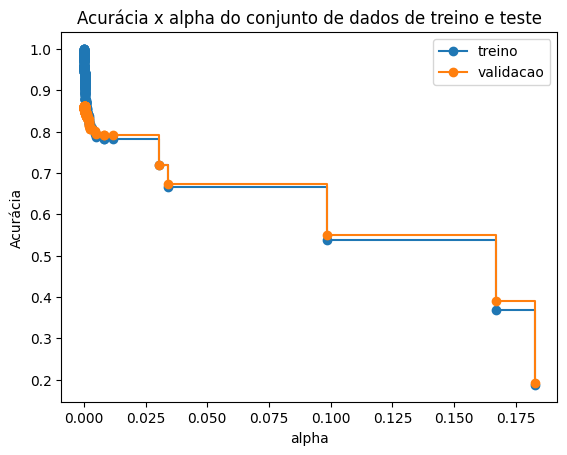

In [82]:
##%%time
train_scores = [clf.score(X_train, y_train) for clf in clfs]
valid_scores = [clf.score(X_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
ax.plot(ccp_alphas_aux, train_scores, marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas_aux, valid_scores, marker='o', label="validacao",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [78]:
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')

melhor_arvore

Acurácia da melhor árvore na base de validação: 86.17


DecisionTreeClassifier(ccp_alpha=np.float64(0.0002959332300649666),
                       random_state=999889006)

### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

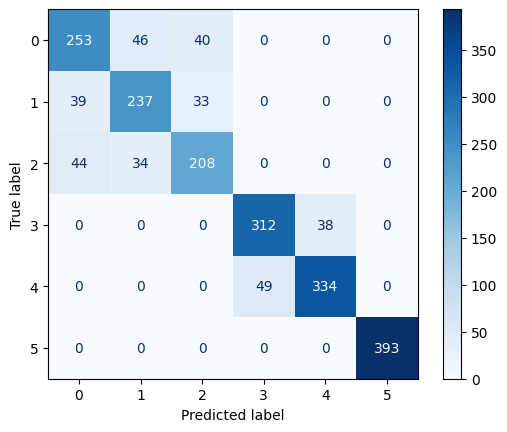

In [79]:
# Gerando as previsões com o melhor modelo (melhor_arvore)
y_pred = melhor_arvore.predict(X_test)

# Gerando a matriz de confusão
matrix = confusion_matrix(y_test, y_pred)

# Exibindo a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap="Blues")

In [83]:
TP = matrix[1, 1]  # Verdadeiros positivos
FP = matrix[0, 1]  # Falsos positivos

# Calculando a acurácia do Modelo
precision = TP / (TP + FP)
print(f"Acurácia na base de testes: {precision}")

Acurácia na base de testes: 0.8374558303886925


Ficou com uma Acurácia um pouco menor do que na base de validação, mesmo assim, com uma acurácia ainda muito boa para o modelo, melhor do que a realizada anteriormente com apenas as 3 primeiras variáveis.